In [19]:
import pandas as pd
import re
import sklearn.metrics
import nltk
import nlpaug.augmenter.word as naw
import numpy as np

import nltk

In [20]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [36]:
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from scipy.stats import uniform
from scipy import interp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,roc_auc_score, recall_score, f1_score, average_precision_score


In [5]:

# load the data from the csv file
train_data = pd.read_csv("reviews.csv")
# train_label = train_data["Sentiment"]
original_data = pd.DataFrame(train_data["Text"])


In [5]:
# define a function to preprocess the text data
def preprocess_text(text):
    # convert to lowercase
    text = text.lower()
    # remove non-alphabetic characters
    text = re.sub(r'[^a-z]', ' ', text)
    # tokenize the text into words
    tokens = word_tokenize(text)
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tokens= ' '.join(tokens)
    return tokens


# remove the html symbol
def remove_html(text):
    regex = r"<[^>]+>"
    text_new = re.sub(regex, " ", text)
    return text_new

# apply the preprocessing function to the text data
train_data['Text'] = train_data['Text'].apply(remove_html)
train_data['Text'] = train_data['Text'].apply(preprocess_text)


In [6]:

# define an NLPAug data augmentation function
def augment_text(text):
    # define an augmentation method
    aug = naw.SynonymAug(aug_src='wordnet', lang='eng')
    # apply the augmentation method to the text
    augmented_text = aug.augment(text)
    return augmented_text

# apply the augmentation function to the preprocessed text data
train_data['Text'] = train_data['Text'].apply(augment_text)

In [7]:
# over sampling
ros = RandomOverSampler(sampling_strategy='minority')

X = train_data['Text'].values.reshape(-1, 1)
y = train_data['Sentiment']
X_resampled, y_resampled = ros.fit_resample(X, y)
train_data = pd.DataFrame({'Text': X_resampled.ravel(), 'Sentiment': y_resampled})



In [8]:
# save the data to a new csv file
train_data.to_csv("oversampling_reviews.csv", index=False)

## Features

In [9]:
# train a Word2Vec model on the preprocessed text data
word2vec_model = Word2Vec(train_data['Text'], min_count=1)

# create a function to generate the word embedding vectors for each sentence
def generate_word_embedding(sentence):
    # initialize an empty array for the sentence vector
    sentence_vector = []
    # loop through each word in the sentence
    for word in sentence:
        try:
            # add the vector representation of the word to the sentence vector
            word_vector = word2vec_model.wv[word]
            sentence_vector.append(word_vector)
        except KeyError:
            # ignore words that are not in the vocabulary
            pass
    # take the mean of the word vectors to get the sentence vector
    sentence_vector = np.mean(sentence_vector, axis=0)
    return sentence_vector

In [10]:
# apply the generate_word_embedding() function to the preprocessed text data
train_data['embedding'] = train_data['Text'].apply(generate_word_embedding)

In [11]:
# create a new DataFrame for the feature matrix
embedding_size = word2vec_model.vector_size
features_df = pd.DataFrame(train_data['embedding'].tolist(), columns=[f'embedding_{i}' for i in range(embedding_size)])

In [12]:
# perform PCA with n_components set to retain 98% of variance
pca_emb = PCA(n_components=0.98)
features_emb_pca = pca_emb.fit_transform(features_df)

# create a new DataFrame for the PCA features
pca_emb_cols = [f"PC_emb{i+1}" for i in range(features_emb_pca.shape[1])]
pca_df_emb = pd.DataFrame(features_emb_pca, columns=pca_emb_cols)

In [13]:
# create a TF-IDF vectorizer object
tfidf_vectorizer = TfidfVectorizer()

# fit and transform the vectorizer on the preprocessed text data
tfidf_matrix = tfidf_vectorizer.fit_transform(train_data['Text'].apply(lambda x: ' '.join(x)))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_features_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)

In [14]:

## standardize the features
#scaler = StandardScaler()
#features_std = scaler.fit_transform(features)

# perform PCA with n_components set to retain 95% of variance
pca = PCA(n_components=0.95)
features_tfidf_pca = pca.fit_transform(tfidf_features_df)

# create a new DataFrame for the PCA features
pca_tfidf_cols = [f"PC_tfidf{i+1}" for i in range(features_tfidf_pca.shape[1])]
pca_df_tfidf = pd.DataFrame(features_tfidf_pca, columns=pca_tfidf_cols)

In [15]:
# add the TF-IDF features to the feature matrix DataFrame
features_df = pd.concat([pca_df_tfidf, pca_df_emb], axis=1)

In [16]:
# add the number of characters, number of words, and number of capital characters as features
features_df['num_characters'] = train_data['Text'].apply(lambda x: len(' '.join(x)))
features_df['num_words'] = train_data['Text'].apply(lambda x: len(x))

In [17]:
# add the common features from the features.csv file
features_df['num_sentences'] = original_data["Text"].apply(lambda s: s.count('.'))
features_df['num_question_marks'] = original_data["Text"].apply(lambda s: s.count('?'))
features_df['num_exclamation_marks'] = original_data["Text"].apply(lambda s: s.count('!'))
features_df['num_unique_words'] = train_data["Text"].apply(lambda x: len(set(x)))

In [18]:
# add the label column to the feature matrix DataFrame
label = features_df.columns
features_df['Sentiment'] = train_data['Sentiment']

In [19]:

# weight the negative sentiment samples by 1.5
features_df.loc[features_df['Sentiment'] == 'negative',label] *= 2


In [29]:
features_df.head()


,PC_tfidf1,PC_tfidf2,PC_tfidf3,PC_tfidf4,PC_tfidf5,PC_tfidf6,PC_tfidf7,PC_tfidf8,PC_tfidf9,PC_tfidf10,...,PC_emb96,PC_emb97,PC_emb98,num_characters,num_words,num_sentences,num_question_marks,num_exclamation_marks,num_unique_words,Sentiment
0,-0.071812,0.036136,0.076162,0.058094,0.015693,-0.068980,-0.009392,0.050062,-0.086675,-0.005748,...,-0.007832,-0.004934,0.000907,98,1,4.0,0.0,0.0,1,positive
1,-0.130083,0.064077,0.186264,0.178121,0.043476,-0.063714,0.012203,0.060614,-0.090439,0.010428,...,0.008681,-0.003294,-0.003709,232,1,4.0,0.0,0.0,1,positive
2,-0.090828,0.038738,0.086590,0.030063,0.018296,0.020041,0.000002,0.236875,-0.103662,-0.137266,...,-0.002308,0.007702,-0.007528,541,1,9.0,0.0,0.0,1,positive
3,-0.032244,0.003467,0.016679,-0.011835,-0.005652,-0.009966,0.012565,0.031322,-0.033928,-0.066652,...,-0.001196,-0.003016,0.003852,311,1,3.0,0.0,2.0,1,positive
4,0.051115,-0.117562,0.050717,-0.013965,-0.013435,-0.031462,-0.059974,0.022282,0.005212,0.054587,...,0.007418,0.000506,0.007445,216,1,4.0,0.0,1.0,1,positive


In [ ]:
# save the feature matrix to a CSV file
# pca_df_emb.to_csv("pca_df_emb.csv", index=False)
# pca_df_tfidf.to_csv("pca_df_tfidf.csv", index=False)
#features_df.to_csv("features.csv", index=False)

In [74]:
train_data=pd.read_csv("features_train.csv")
train_data['tag'] = train_data['Sentiment'].map(dict(positive=1, negative=0))
train_data.head()

,PC_tfidf1,PC_tfidf2,PC_tfidf3,PC_tfidf4,PC_tfidf5,PC_tfidf6,PC_tfidf7,PC_tfidf8,PC_tfidf9,PC_tfidf10,...,PC_tfidf2554,PC_tfidf2555,PC_tfidf2556,PC_tfidf2557,PC_tfidf2558,PC_tfidf2559,PC_tfidf2560,PC_emb1,Sentiment,tag
0,0.125620,0.086304,0.047654,-0.053766,0.016895,0.006636,0.057737,0.058247,-0.071434,-0.030766,...,-0.014703,-0.006541,0.001270,-0.003647,0.001165,-0.010708,0.001703,0.604965,positive,1
1,-0.042603,0.000193,0.029059,-0.059601,0.039494,-0.034193,-0.002060,-0.108345,0.023581,0.000313,...,-0.011572,-0.001005,-0.017747,-0.023063,0.016968,0.004904,0.006062,-0.559065,positive,1
2,-0.034431,0.010012,-0.002671,-0.044581,0.023652,-0.001375,-0.012137,0.003543,0.012075,0.002073,...,-0.001365,-0.001086,-0.023059,-0.016890,0.004170,-0.000059,0.002757,-0.793231,positive,1
3,0.043434,-0.051018,0.289668,0.091026,-0.011638,0.069017,-0.082393,-0.098824,0.048846,0.005609,...,-0.013448,-0.030621,0.013245,0.006127,-0.004246,-0.032258,-0.010947,0.266332,positive,1
4,-0.056289,0.006874,-0.029635,0.055384,0.078201,-0.057992,-0.012327,0.003309,-0.023922,0.024825,...,-0.007892,0.000735,0.006927,-0.008579,0.009152,0.012545,-0.008741,-0.111557,positive,1


In [75]:
test_data=pd.read_csv("features_test.csv")
test_data['tag'] = test_data['Sentiment'].map(dict(positive=1, negative=0))
test_data.head()

,PC_tfidf1,PC_tfidf2,PC_tfidf3,PC_tfidf4,PC_tfidf5,PC_tfidf6,PC_tfidf7,PC_tfidf8,PC_tfidf9,PC_tfidf10,...,PC_tfidf2554,PC_tfidf2555,PC_tfidf2556,PC_tfidf2557,PC_tfidf2558,PC_tfidf2559,PC_tfidf2560,PC_emb1,Sentiment,tag
0,0.003003,-0.007670,-0.024751,-0.008711,0.048035,0.080845,0.019316,-0.005109,-0.019494,-0.001264,...,-0.004350,-0.003682,-0.012045,-0.008119,-0.002653,-0.013525,-0.008150,0.293276,positive,1
1,0.016410,-0.038728,0.026165,0.052852,0.075277,0.048377,-0.014616,0.008187,0.018016,-0.063928,...,-0.010688,-0.014109,-0.017873,0.003445,0.010449,0.003113,-0.013101,0.530278,positive,1
2,-0.024891,0.015307,-0.025498,-0.047200,0.110320,0.032510,0.038903,0.027520,0.126051,-0.172537,...,-0.011773,-0.004405,0.000392,0.006039,0.004289,0.001587,0.004968,0.561678,positive,1
3,-0.020077,0.006177,-0.009455,-0.019804,-0.004952,0.032510,-0.005290,-0.004231,0.018715,-0.004419,...,-0.015926,0.002942,-0.002900,-0.002967,-0.003947,0.013005,0.012213,-0.219977,positive,1
4,-0.032384,0.010378,-0.005000,-0.041640,0.010491,0.040683,-0.012633,-0.010550,-0.003390,0.012361,...,-0.001538,0.008185,0.000329,0.001891,-0.015470,0.000781,-0.013583,0.209119,positive,1


In [73]:

def result(predictions,actual):
    print("F1 score: ", f1_score(actual, predictions))
    print("PR_AUC score: ", average_precision_score(actual, predictions))
    print("ROC_AUC score: ", roc_auc_score(actual, predictions))
    print("Accuracy: ", accuracy_score(actual, predictions))

In [55]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin 
from sklearn.svm import LinearSVC 
from sklearn.pipeline import Pipeline 

import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score


import numpy as np
import pandas as pd
import nltk
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from imblearn.over_sampling import RandomOverSampler, SMOTE

def text_cleaning(text):
    return clean_text.label().lower_case()


def spacy_tokenizer(doc):
    return [x.orth_ for x in nlp(doc)]

vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
classifier = LinearSVC()
tfvectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer)

reviews_csv = pd.read_csv('reviews.csv')

# Function to convert text to lowercase
def convert_to_lower(text):
    return text.lower()

# Removes html notation, such as <br/>
def remove_html(text):
    regex = r"<[^>]+>"
    text_new = re.sub(regex, " ", text)
    return text_new

# Function to remove numbers and other numeric values
def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

# Function to remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Function to remove stopwords
def remove_stopwords(text):
    removed = []
    stop_words = list(stopwords.words("english"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)

# Function to remove extra white spaces
def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

# Function to Lemmatize
def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)


reviews_csv['Text'] = reviews_csv['Text'].apply(lambda x: convert_to_lower(x))
reviews_csv['Text'] = reviews_csv['Text'].apply(lambda x: remove_html(x))
reviews_csv['Text'] = reviews_csv['Text'].apply(lambda x: remove_numbers(x))
reviews_csv['Text'] = reviews_csv['Text'].apply(lambda x: remove_punctuation(x))
reviews_csv['Text'] = reviews_csv['Text'].apply(lambda x: remove_stopwords(x))
reviews_csv['Text'] = reviews_csv['Text'].apply(lambda x: remove_extra_white_spaces(x))
reviews_csv['Text'] = reviews_csv['Text'].apply(lambda x: lemmatizing(x))


X = reviews_csv['Text']

label_map = {
    'positive': 1,
    'negative': 0,
}
reviews_csv['sentiment_label'] = reviews_csv['Sentiment'].map(label_map)
ylabels = reviews_csv['sentiment_label']

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.25, random_state=42)
X_train

[nltk_data] Downloading package punkt to /Users/xuxingyu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/xuxingyu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xuxingyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3824    packaged well healthy arrival held month later...
2380    admit hard time identifying difference bottled...
1263    cheese ball hard findand goodthey melt mouth c...
5095    soup flavor broth slimy consistency instead li...
999     tasty treatwith thin layer sugary jelly middle...
                              ...                        
3772    used bag far pleasantly surprised bad bean bag...
5191    jam little fruit taste love damson jam one cou...
5226    ugh stuff may good appealing mixed oatmeal fin...
5390    chicken strip others like priced low hard resi...
860     ive fgound cure drinking much coffee inthe mor...
Name: Text, Length: 4083, dtype: object

## XGBOOST























In [76]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [77]:
X_train=train_data.iloc[: , :-2]
y_train=train_data['tag']
X_test=test_data.iloc[: , :-2]
y_test=test_data['tag']

In [91]:
y_test.value_counts()

1    1209
0     425
Name: tag, dtype: int64

In [78]:
#RandomSearchCV
# define the parameters to tune
param_dist = {"learning_rate": uniform(0, 2),
              "gamma": uniform(1, 0.000001),
              "max_depth": range(1,50),
              "n_estimators": range(1,300),
              "min_child_weight": range(1,10),
              'n_jobs': range(1,5)}
#instance of RandomSearchCV
rs = RandomizedSearchCV(XGBClassifier(), param_distributions=param_dist, n_iter=3)

In [79]:
rs.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_c...
                                           predictor=None, random_state=None,
                                    

In [80]:
y_preds=rs.predict_proba(X_test)


In [87]:
y_ppp=rs.predict(X_test)

In [89]:
print("F1 score: ", f1_score(y_test, y_ppp))
print("PR_AUC score: ", average_precision_score(y_test, svml_pred_prob_df['POSITIVE'] ))
print("ROC_AUC score: ", roc_auc_score(y_test, svml_pred_prob_df['POSITIVE']))
print("Accuracy: ", accuracy_score(y_test, y_ppp))

F1 score:  0.9481946624803769
PR_AUC score:  0.9961545866349206
ROC_AUC score:  0.9897795942198221
Accuracy:  0.9192166462668299


In [81]:
svml_pred_prob_df = pd.DataFrame(data = y_preds, columns = ['NEGATIVE', 'POSITIVE'])
svml_pred_prob_df

,NEGATIVE,POSITIVE
0,0.000022,0.999978
1,0.000001,0.999999
2,0.001099,0.998901
3,0.000001,0.999999
4,0.000010,0.999990
...,...,...
1629,0.999998,0.000002
1630,0.135331,0.864669
1631,0.942108,0.057892
1632,0.658752,0.341248


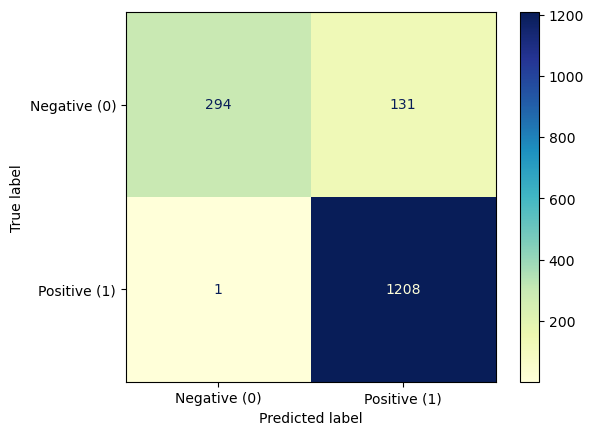

In [88]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
labels = ['Negative (0)', 'Positive (1)']
cm = confusion_matrix(test_data['tag'], y_ppp)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(cmap = 'YlGnBu');

In [37]:
result(y_test, y_preds)

F1 score:  0.9393939393939393
PR_AUC score:  0.9811855219443959
ROC_AUC score:  0.9428571428571428
Accuracy:  0.9045287637698899


## Ramdon Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV



In [39]:
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5,50,100],
    'max_depth': [2,10,20,None]
}

cv = GridSearchCV(rf,parameters)
cv.fit(X_train, y_train)
y_preds=cv.predict(X_test)

In [40]:
result(y_test, y_preds)

F1 score:  0.8660458452722062
PR_AUC score:  0.9926259035916342
ROC_AUC score:  0.8818698673404928
Accuracy:  0.7711138310893513


In [ ]:
import nltk
import pandas as pd
from flair.data import Sentence
from flair.models import TextClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from transformers import pipeline


In [ ]:
reviews = pd.read_csv('oversampling_reviews.csv')
reviews['tag'] = reviews['Sentiment'].map(dict(positive=1, negative=0))

reviews.head()

In [ ]:

# Download the vader_lexicon data
nltk.download("vader_lexicon")
# Create a sentiment analyzer using NTLK's Vader
analyzer = SentimentIntensityAnalyzer()

def classify_sentiment_ntlk(review: str):
    """
    Classify sentiment using NTLK's Vader
    """
    scores = analyzer.polarity_scores(review)
    return scores['compound']

In [ ]:
def classify_sentiment_textblob(review: str):
    """
    Classify sentiment using TextBlob
    """
    blob = TextBlob(review)
    return blob.sentiment.polarity

In [ ]:

from flair.nn import Classifier
from flair.data import Sentence
from flair.splitter import SegtokSentenceSplitter

tagger = Classifier.load('sentiment')
def classify_sentiment_flair(review):
    """
    Classify sentiment using Flair
    """
    sentence = Sentence(review)
    tagger.predict(sentence)
    return sentence.labels[0].value

In [ ]:
from transformers import pipeline
# Load twitter-roberta-base-sentiment-latest model for sentiment analysis

model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
pipe = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path, max_length=512,truncation=True)



def classify_sentiment_twitter_roberta_base(review):
    """
    Classify sentiment using Twitter-roBERTa-base
    """
    sentiment = pipe(review)
    return sentiment[0]['scores']


In [ ]:

def get_sentiments(reviews):
    results = []
    for review in reviews['Text']:
        
        result = {
            "Review": review,
            "Vader": classify_sentiment_ntlk(review),
            "TextBlob": classify_sentiment_textblob(review),
            "Flair": classify_sentiment_flair(review),
            "Twitter_roBERTa": classify_sentiment_twitter_roberta_base(review),
        }
        results.append(result)
    
    # Return the results as a pandas DataFrame
    return pd.DataFrame(results)

In [ ]:
results = get_sentiments(reviews)
print("Sentiment results: ", results)

In [ ]:
actual=reviews['tag']
def result_per(predictions,actual):
    print("F1 score: ", f1_score(actual, predictions))
    print("PR_AUC score: ", average_precision_score(actual, predictions))
    print("ROC_AUC score: ", roc_auc_score(actual, predictions))
    print("Accuracy: ", accuracy_score(actual, predictions))